In [1]:
import sys
sys.path.append('../60_gebastel/Model/')
sys.path.append('../30_data_tools/')

In [2]:
import torch
from io import BytesIO
from pytorch_model_tools import get_datasets
from file_interaction import download_blob
from tqdm.auto import tqdm
import plotly.express as px
import numpy as np

In [3]:
def calc_metrics( labels, predictions ):
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for i in range(len(labels)):
        diff = labels[i] - predictions[i]

        if diff == 0:
            if labels[i] == 0:
                TP += 1
            else:
                TN += 1
        elif diff == -1:
            FN += 1
        else:
            FP += 1

    out = {
        "count_data" : len(labels), 
        "TP" : TP,
        "TN" : TN,
        "FP" : FP,
        "FN" : FN,
        "accuracy" : (TP + TN) / len(labels),
        "precision" : TP / (TP + FP),
        "recall" : TP / (TP + FN)
    }

    return out

In [4]:
def get_confusion_matrix( metrics, relative=False ):
    values = np.array([
        [metrics['TP'],metrics['FN']],
        [metrics['FP'],metrics['TN']]
    ])

    if relative:
        values = values / metrics['count_data']
    
    return px.imshow(
        values,
        x=['moire','no_moire'],
        y=['moire','no_moire'],
        labels={
            'y' : 'label',
            'x' : 'prediction'
        },
        text_auto=True
    )

In [5]:
model_name = '2024-04-11_resnet50_003'

In [16]:
datasets = get_datasets()

real_val size 1675
test size 16030
train size 104951
val size 7671
class names ['moire']


In [7]:
bytesStream = download_blob( f'models/{ model_name }.pth' )
model = torch.load( BytesIO(bytesStream.getvalue()), map_location=torch.device('cpu') )

In [29]:
labels = []
predictions = []

for X,y in tqdm(datasets['test']['dataloader']):
    pred = model(X)
    labels += y.tolist()
    predictions += torch.argmax(pred, axis=1).tolist()

  0%|          | 0/251 [00:00<?, ?it/s]

In [30]:
metrics = calc_metrics( labels, predictions )

In [31]:
metrics

{'count_data': 16030,
 'TP': 2956,
 'TN': 11679,
 'FP': 420,
 'FN': 975,
 'accuracy': 0.912975670617592,
 'precision': 0.8755924170616114,
 'recall': 0.7519715085220046}

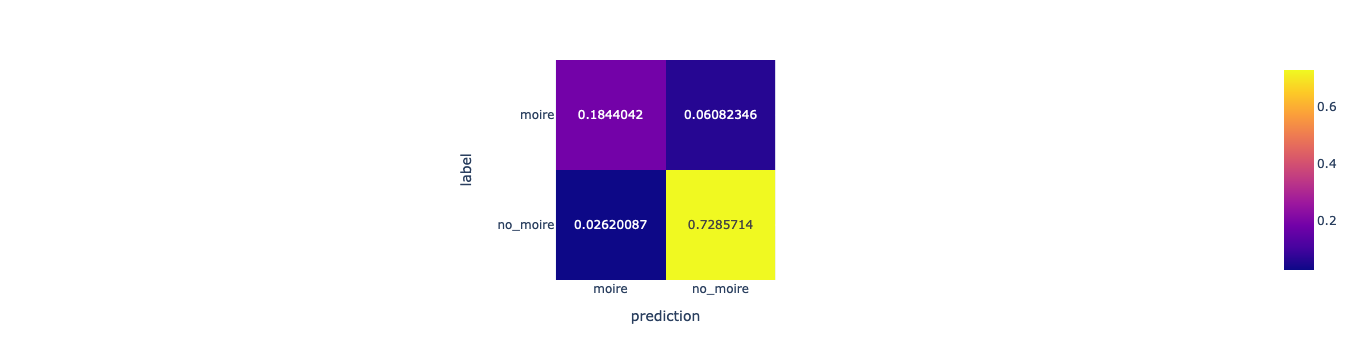

In [32]:
get_confusion_matrix( metrics, relative=True )

In [12]:
from PIL import Image
from PIL import ImageFont, ImageDraw  
from pathlib import Path

In [21]:
tile_paths = list(
    Path('/Users/frederic.birwe/Desktop/azure_transfer/tile_datasets/real_val/moire/').glob('./*.jpg')
)

In [23]:
results = []

for tile_path in tqdm(tile_paths):
    tile = Image.open(tile_path)
    
    with torch.no_grad():
        pred = model(torch.Tensor(np.moveaxis(np.array(tile.resize((224,224))), -1, 0) / 255).reshape((1,3,224,224)))

    results.append((
        tile_path,
        pred,
        int(torch.argmax(pred))
    ))

  0%|          | 0/1675 [00:00<?, ?it/s]

In [24]:
font = ImageFont.load_default()

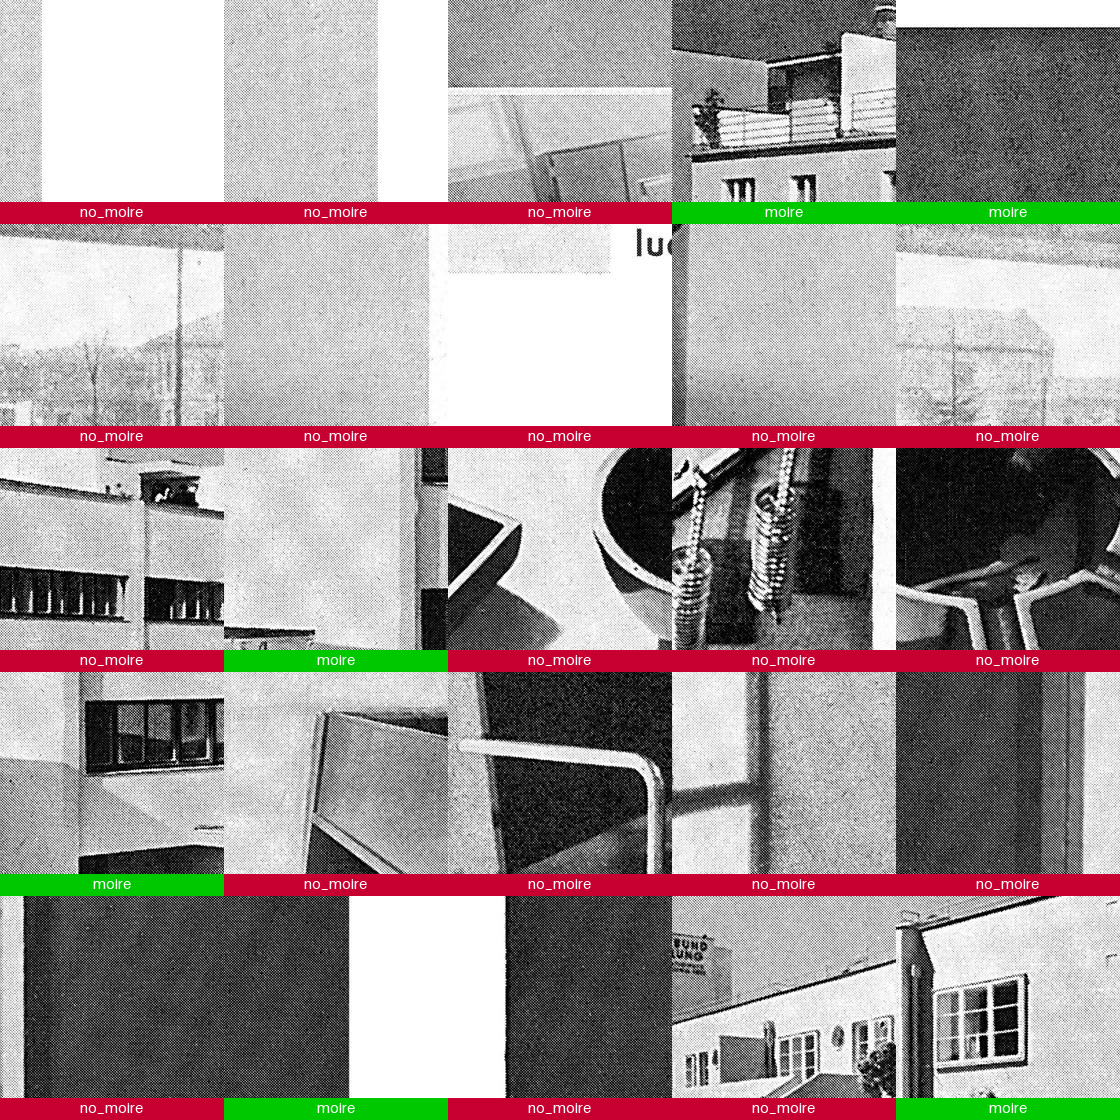

In [28]:
IMG_SIZE = 224

labels = ['moire','no_moire']
grid_size = (5,5)

offset = 0

while offset < len(results):
    out_img = Image.new(
        'RGB',
        (IMG_SIZE * grid_size[0], IMG_SIZE * grid_size[1]),
        color="white"
    )
    draw = ImageDraw.Draw(out_img)  
    label_color=[
        (0,200,0),
        (200,0,50)
    ]
    
    for y in range(grid_size[1]):
        for x in range(grid_size[0]):
            i = y * grid_size[1] + x
    
            if len(results) > offset + i:
                result = results[offset+i]
                tile_img = Image.open( result[0] )
                out_img.paste(
                    tile_img,
                    ( x * tile_img.size[0], y * tile_img.size[1] )
                )
                draw.rectangle(
                    (
                        ( x * tile_img.size[0], y * tile_img.size[1] + round(IMG_SIZE * 0.9) ),
                        ( x * tile_img.size[0] + IMG_SIZE, y * tile_img.size[1] + IMG_SIZE )
                    ),
                    outline=None,
                    fill=label_color[result[2]]
                )
                draw.text(
                    ( x * tile_img.size[0] + round(IMG_SIZE * 0.5), y * tile_img.size[1] + round(IMG_SIZE * 0.97) ),
                    labels[result[2]],
                    anchor='ms',
                    font_size=15
                )
                
    offset += 50
    out_img.save( f'/Users/frederic.birwe/Downloads/tile_grid_{ (str(offset)).zfill(3) }.jpg' )

out_img

In [ ]:
results